In [3]:
#Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
from geopy.geocoders import Nominatim
from sklearn import preprocessing
import pickle
import math
import copy
import matplotlib.dates as mdates
from datetime import datetime, date
from dateutil.relativedelta import relativedelta

#Path to datafile
datapath = "All_zip.csv"
WINDOW_SIZE = 50
LEARNING_RATE = 0.000025
N_EPOCHS = 200
HIDDEN_SIZE = 100
EPOCHS_EARLY = 20

In [9]:
#Data cleaning
class PriceData():

    def __init__(self, filename):
        self.df = self.generateDF(filename)

    def generateDF(self, filename):
        
        def lat(row):
            return geolocator.geocode({"postalcode":row["RegionName"]})[1][0]

        def long(row):
            return geolocator.geocode({"postalcode":row["RegionName"]})[1][1]

        
        orig_df = pd.read_csv(filename)
        filtered_df = orig_df.loc[(orig_df['State'] == "CA")]
        
        

        columns = filtered_df.columns
        

        cal_df = filtered_df \
            .dropna() \
            .drop(columns=columns[3:9]) \
            .drop(columns=columns[0:2]) \
            .rename(columns={'RegionName': 'ZipCode'}) \
            .reset_index(drop=True)
        
        
        cal_df.set_index("ZipCode", inplace = True)

#         for zip_code in cal_df.index:
#             print(zip_code)
#             cal_df["windows"] = cal_df.apply(lambda row: createBatches(row["prices"]), axis = 1)
        

        return cal_df

In [10]:
class LSTM(nn.Module):
    
    def __init__(self,input_size = 1, window_size = WINDOW_SIZE, hidden_size = HIDDEN_SIZE, out_size = 1, learning_rate = LEARNING_RATE, epochs = N_EPOCHS):

        super().__init__()
        
        #Model
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size,out_size)
        self.hidden = (torch.zeros(1,1,hidden_size),torch.zeros(1,1,hidden_size))
        self.window_size = None
        self.prices = None
        self.window_size = window_size
        
        #Data processing
        self.scaler = None
        
        #Training parameters
        self.criterion = nn.MSELoss()
        self.optimiser = torch.optim.Adam(self.parameters(), lr=learning_rate)
        
        
        #Hyperparameters
        self.epochs = epochs
        
        
        
    
    def _preprocessor(self, ySeries):
        y = ySeries.values

        
        
        window_size = self.window_size

        out = []
        self.prices = y[:window_size].reshape(window_size)
        for i in range(len(y) - window_size):
            scaler = preprocessing.MinMaxScaler()
            y_scaled = scaler.fit_transform(y[i:i+window_size+1].reshape(-1, 1))
            self.scaler = scaler
            window = torch.tensor(y_scaled[:window_size]).to(torch.float32)
            label = torch.tensor(y_scaled[window_size:window_size+1]).to(torch.float32)
            self.prices = np.append(self.prices, y[i+window_size:i+window_size+1][0])
            out.append((window, label))
        return out
    
    def fit(self, y, y_val):
        y_train = self._preprocessor(y)
        
        epochs_wo_imp = 0
        lowest_rmse = math.inf
        val_rmse = math.inf
        
        
        for epoch in range(self.epochs):
            for seq, y_hat in y_train:
                self.optimiser.zero_grad()
                self.hidden = (torch.zeros(1,1,self.hidden_size), torch.zeros(1,1,self.hidden_size))

                y_pred = self(seq)
                loss = self.criterion(y_hat[0], y_pred)
                loss.backward() 
                self.optimiser.step()
            
            val_rmse = self.score(y_val)[0]
            
            if (val_rmse < lowest_rmse):
                best_model = copy.deepcopy(self)
                best_model.prices = np.append(best_model.prices, y_val)
                lowest_rmse = val_rmse
                epochs_wo_imp = 0
            else:
                epochs_wo_imp += 1
                
            if (epochs_wo_imp == EPOCHS_EARLY):
                return best_model, lowest_rmse
            
            print(f'Epoch: {epoch+1:2} Test Loss: {loss.item():10.8f} Val RMSE: {val_rmse}')
            
        return (best_model, lowest_rmse)
                
            
    def predict(self, future_instances):
        
        self.eval()
        for i in range(future_instances):
            scaler = preprocessing.MinMaxScaler()
            seq = torch.FloatTensor(scaler.fit_transform(self.prices[-self.window_size:].reshape(-1, 1)))
            self.scaler = scaler
            with torch.no_grad():
                self.hidden = (torch.zeros(1,1,self.hidden_size),
                                torch.zeros(1,1,self.hidden_size))
                self.prices = np.append(self.prices, self.scaler.inverse_transform(np.array(self(seq).item()).reshape(-1, 1)))
        
        predictions = self.prices[-future_instances:]
        self.prices = self.prices[:-future_instances]
        return predictions
    
    def predict_inplace(self, future_instances):
        
        self.eval()
        for i in range(future_instances):
            scaler = preprocessing.MinMaxScaler()
            seq = torch.FloatTensor(scaler.fit_transform(self.prices[-self.window_size:].reshape(-1, 1)))
            self.scaler = scaler
            with torch.no_grad():
                self.hidden = (torch.zeros(1,1,self.hidden_size),
                                torch.zeros(1,1,self.hidden_size))
                self.prices = np.append(self.prices, self.scaler.inverse_transform(np.array(self(seq).item()).reshape(-1, 1)))
        
        predictions = self.prices[-future_instances:]
        return predictions
    
    def score(self, y):
        y_pred = self.predict(len(y))
        rmse = np.sqrt(np.mean(((np.array(y_pred)-np.array(y)))**2))
        return rmse, y_pred

        
        
    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]

In [11]:
def split_dataset(y, valid_proportion, test_proportion):

   
    
    n_test = round(len(y) * test_proportion)
    n_valid = round(len(y) * valid_proportion)
    n_train = (len(y) - n_test) - n_valid
    
    y_train = y[:n_train]
    y_valid = y[n_train:n_train + n_valid]
    y_test = y[n_train + n_valid:]
    
    return (y_train, y_valid, y_test)


def save_regressor(trained_model, zipcode): 
    """ 
    Utility function to save the trained regressor model in part2_model.pickle.
    """
    # If you alter this, make sure it works in tandem with load_regressor
    with open(str(zipcode) + '_model.pickle', 'wb') as target:
        pickle.dump(trained_model, target)
    print(f"\nSaved model in {zipcode}_model.pickle\n")


def load_regressor(zipcode): 
    """ 
    Utility function to load the trained regressor model in part2_model.pickle.
    """
    # If you alter this, make sure it works in tandem with save_regressor
    with open(str(zipcode) + '_model.pickle', 'rb') as target:
        trained_model = pickle.load(target)
    print(f"\nLoaded model in {zipcode}_model.pickle\n")
    return trained_model

    

Evaluating Model for ZipCode 90044

Loaded model in 90044_model.pickle

Window size: 50 Hidden size: 100
RMSE: 64332.744663447804


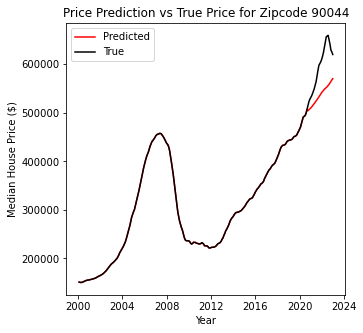

In [48]:
def hyperparameterSearch(df, window_sizes = [10, 20, 40, 80, 100], hidden_sizes = [10, 20, 40, 60, 80, 100, 150], zipcode = 91331):
    lowest_rmse = math.inf
    val_rmse = math.inf
    

    for window_size in window_sizes:
        WINDOW_SIZE = window_size
        for hidden_size in hidden_sizes:
            HIDDEN_SIZE = hidden_size
            
            print(f"Fitting for window_size of {WINDOW_SIZE} and hidden size of {HIDDEN_SIZE}")
            y = df.loc[zipcode]

            y_train, y_valid, y_test = split_dataset(y, 0.1, 0.1)

            model = LSTM(window_size = WINDOW_SIZE, hidden_size = HIDDEN_SIZE)
            model, val_rmse = model.fit(y_train, y_valid)
            print(f"Model trained for window_size of {model.window_size} and hidden size of {model.hidden_size}")


            if (val_rmse < lowest_rmse):
                best_model = copy.deepcopy(model)
                lowest_rmse = val_rmse
                
    save_regressor(best_model,zipcode)
    return best_model

def evaluate(zipcode, df):
    model = load_regressor(zipcode)
    print("Window size:", model.window_size, "Hidden size:", model.hidden_size)
    y = cal_df.loc[zipcode]
    y_train, y_valid, y_test = split_dataset(y, 0.1, 0.1)
    test_rmse, y_preds = model.score(y_test)
    print("RMSE:", test_rmse)

    
    dates = pd.to_datetime(cal_df.columns)
    predicted_prices = np.append(model.prices, y_preds)
    golden_prices = np.append(y_train, np.append(y_valid, y_test))
    # Create a figure and axis object
#     fig, ax = plt.subplots(figsize = (16, 9))
    plt.figure(figsize=(5,5))
    plt.plot(dates, predicted_prices, 'red')
    plt.plot(dates, golden_prices, 'black')
    plt.xlabel('Year')
    plt.ylabel('Median House Price ($)')
    plt.title(f'Predicted Price vs True Price for Zipcode {zipcode}')
    plt.legend(['Predicted', 'True'])
    # format x-axis tick labels to show only the year
    years = mdates.YearLocator()
    year_format = mdates.DateFormatter('%Y')
#     plt.xaxis.set_major_locator(years)
#     plt.xaxis.set_major_formatter(year_format)
    
    plt.savefig(f'{zipcode}_plot_model_test.png')
    plt.show()
                

if __name__ == "__main__":
    cal_df = PriceData(datapath).df
    zip_codes = [90044]
    
    for zip_code in zip_codes:
# # #         print(f"Training Model for ZipCode {zip_code}")
# # #         hyperparameterSearch(zipcode = zip_code, df = cal_df)

        print(f"Evaluating Model for ZipCode {zip_code}")
        evaluate(zip_code, cal_df)

In [49]:
def save_regressor_deploy(trained_model, zipcode): 
    """ 
    Utility function to save the trained regressor model in part2_model.pickle.
    """
    # If you alter this, make sure it works in tandem with load_regressor
    with open(str(zipcode) + '_deploy_model.pickle', 'wb') as target:
        pickle.dump(trained_model, target)
    print(f"\nSaved model in {zipcode}_model.pickle\n")


def load_regressor_deploy(zipcode): 
    """ 
    Utility function to load the trained regressor model in part2_model.pickle.
    """
    # If you alter this, make sure it works in tandem with save_regressor
    with open(str(zipcode) + '_deploy_model.pickle', 'rb') as target:
        trained_model = pickle.load(target)
    print(f"\nLoaded model in {zipcode}_model.pickle\n")
    return trained_model

# if __name__ == "__main__":
#     cal_df = PriceData(datapath).df
#     zip_codes = [91331, 90201, 90044, 90280, 93307]
    
#     for zip_code in zip_codes:
#         model = load_regressor(zip_code)
#         WINDOW_SIZE = model.window_size
#         HIDDEN_SIZE = model.hidden_size
#         print(f"Fitting for window_size of {WINDOW_SIZE} and hidden size of {HIDDEN_SIZE}")
#         y = cal_df.loc[zip_code]

#         y_train, y_valid, y_test = split_dataset(y, 0.1, 0)

#         model = LSTM(window_size = WINDOW_SIZE, hidden_size = HIDDEN_SIZE)
#         model, val_rmse = model.fit(y_train, y_valid)
#         print(f"Model trained for window_size of {model.window_size} and hidden size of {model.hidden_size}")
#         save_regressor_deploy(model, zip_code)


In [55]:
def count_months(date1, date2):
    
    # calculate number of months between the two dates
    num_days = relativedelta(date2, date1).days
    num_months = relativedelta(date2, date1).months
    num_years = relativedelta(date2, date1).years
    
    months = num_years*12 + num_months + int(num_days > 15)
    
    return months

int()
if __name__ == "__main__":
    #Get user input
    date_user = input("Please enter the date you are planning to buy the house (YYYY-MM-DD):")
    cur_price = float(input("Please enter the current price of the house in USD($):"))
    zip_code = int(input("Please enter the zipcode of the house:"))
    
    #Get 3 dates
    last_date = datetime.strptime('2022-12-31', '%Y-%m-%d').date()
    date_today = date.today()
    date_user = datetime.strptime(date_user, '%Y-%m-%d').date()
    
    #Count number of predictions to be made
    num_preds = count_months(last_date, date_user)
    num_preds_till_today = count_months(last_date, date_today)
    
    #Load model and make predictions
    model = load_regressor_deploy(zip_code)
    price_predictions = model.predict(num_preds)
    
    today_median = price_predictions[num_preds_till_today - 1]
    final_median = price_predictions[-1]
    
    scaling_factor = final_median/today_median
    predicted_price = cur_price*scaling_factor
    
    print("The predicted price of the house is:", predicted_price)

    

Please enter the date you are planning to buy the house (YYYY-MM-DD):2033-03-16
Please enter the current price of the house in USD($):500000
Please enter the zipcode of the house:90044

Loaded model in 90044_model.pickle

The predicted price of the house is: 955624.6418416569
